Aircraft Analysis
=========================

Example how to use the software included in the docker image.

Sample analysis file for glider with rg15 airfoil

Results can be compared to xflr5 analysis done in https://www.rcsoaringdigest.com/pdfs/RCSD-2008/RCSD-2008-02.pdf


In [131]:
from aerosandbox import *
import plotly.io as pio
pio.renderers.default = "jupyterlab"

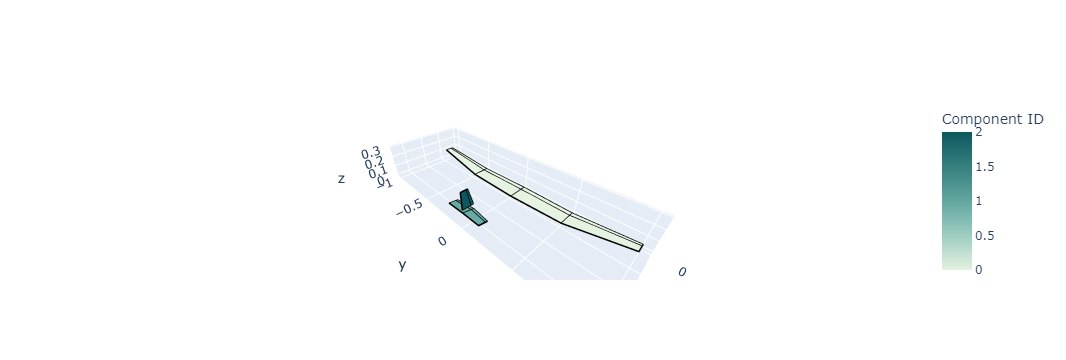

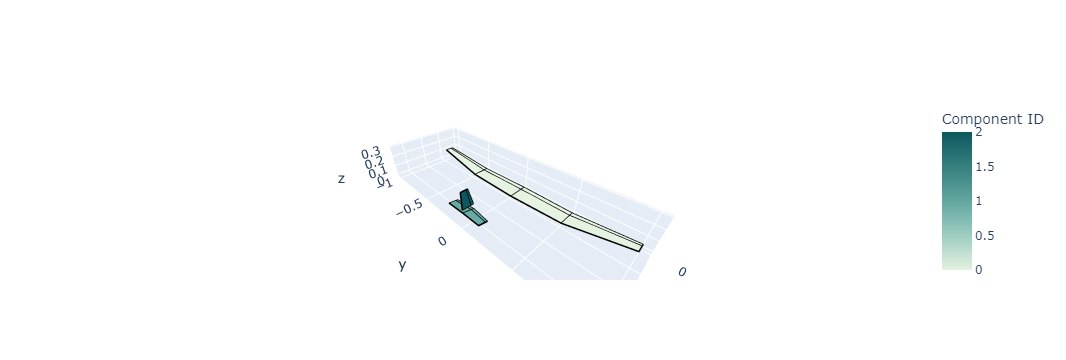

In [132]:
rg15 = Airfoil(name="rg15").repanel(50)

glider = Airplane(
    name="Peter's Glider",
    xyz_ref=[0, 0, 0],  # CG location
    wings=[
        Wing(
            name="Main Wing",
            xyz_le=[0, 0, 0],  # Coordinates of the wing's leading edge
            symmetric=True,  # Should we mirror the wing across the XZ plane?
            xsecs=[  # The wing's cross ("X") sections
                WingXSec(  # Root cross ("X") section
                    xyz_le=[0, 0, 0],  # Coordinates of the XSec's leading edge, relative to the wing's leading edge.
                    chord=0.18,
                    twist_angle=2,  # degrees
                    airfoil=rg15,
                    control_surface_is_symmetric=True,
                    # Flap # Control surfaces are applied between a given XSec and the next one.
                    control_surface_deflection=0,  # degrees
                    control_surface_hinge_point=0.75  # as chord fraction
                ),
                WingXSec(  # Mid
                    xyz_le=[0.01, 0.5, 0],
                    chord=0.16,
                    twist_angle=0,
                    airfoil=rg15,
                    control_surface_is_symmetric=False,  # Aileron
                    control_surface_deflection=0,
                    control_surface_hinge_point=0.75
                ),
                WingXSec(  # Tip
                    xyz_le=[0.08, 1, 0.1],
                    chord=0.08,
                    twist_angle=-2,
                    airfoil=rg15,
                )
            ]
        ),
        Wing(
            name="Horizontal Stabilizer",
            xyz_le=[0.6, 0, 0.1],
            symmetric=True,
            xsecs=[
                WingXSec(  # root
                    xyz_le=[0, 0, 0],
                    chord=0.1,
                    twist_angle=-10,
                    airfoil=Airfoil(name="naca0012"),
                    control_surface_is_symmetric=True,  # Elevator
                    control_surface_deflection=0,
                    control_surface_hinge_point=0.75
                ),
                WingXSec(  # tip
                    xyz_le=[0.02, 0.17, 0],
                    chord=0.08,
                    twist_angle=-10,
                    airfoil=Airfoil(name="naca0012")
                )
            ]
        ),
        Wing(
            name="Vertical Stabilizer",
            xyz_le=[0.6, 0, 0.15],
            symmetric=False,
            xsecs=[
                WingXSec(
                    xyz_le=[0, 0, 0],
                    chord=0.1,
                    twist_angle=0,
                    airfoil=Airfoil(name="naca0012"),
                    control_surface_is_symmetric='symmetric',  # Rudder
                    control_surface_deflection=0,
                    control_surface_hinge_point=0.75
                ),
                WingXSec(
                    xyz_le=[0.04, 0, 0.15],
                    chord=0.06,
                    twist_angle=0,
                    airfoil=Airfoil(name="naca0012")
                )
            ]
        )
    ]
)

glider.draw() 

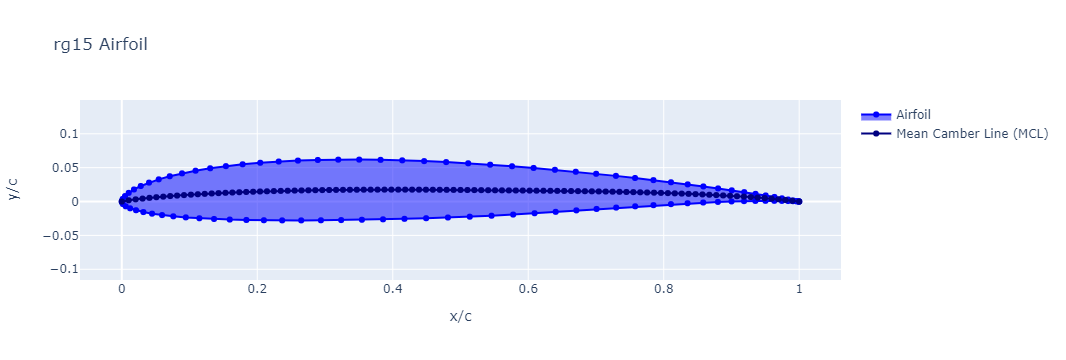

In [133]:
airfoil = rg15
airfoil.draw()

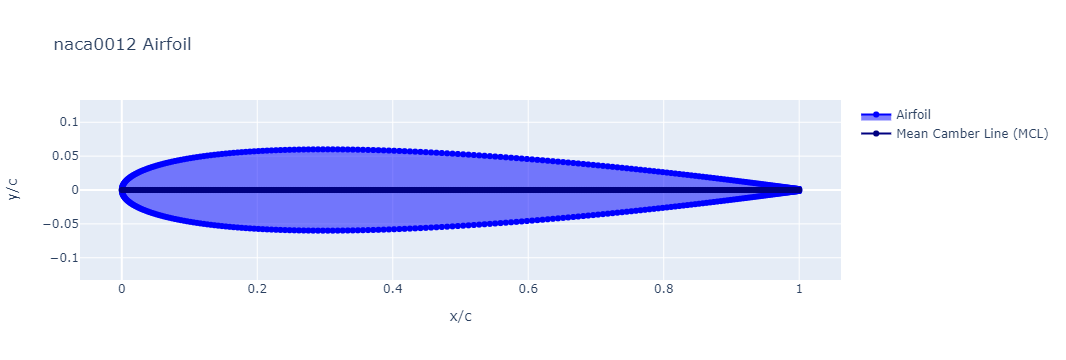

In [134]:
airfoil = Airfoil(name="naca0012")
airfoil.draw()

Polars for RG15 Airfoil
=======================

Calculate the polars for rg15 to compare to xflr5.  There is example calculations for rg15 and can compared to an analysis done at https://www.rcsoaringdigest.com/pdfs/RCSD-2008/RCSD-2008-02.pdf

In [139]:
from aerosandbox import *
reynolds = [10000,20000,30000,50000,100000,150000,200000,300000,500000]
polars = {}
for re in reynolds:
    xf = XFoil(
        airfoil=rg15,
        Re=re,
        max_iter=40
    )
    polars[re] = xf.alpha(np.arange(-3, 9, .25))

In [142]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

def graphPolars(polars):
    reynolds = polars.keys()
    # setup colors
    increment = 0
    palette = sns.color_palette(None, len(reynolds)).as_hex()
    reynolds_color={}
    for re in reynolds:
        reynolds_color[re] = palette[increment]
        increment = increment + 1
    

    # Initialize figure with subplots
    fig = make_subplots(
        rows=3, cols=2, vertical_spacing = 0.07, horizontal_spacing = 0.07, 
        subplot_titles=("CL Vs. CD", "CL Vs alpha", "CM Vs alpha", "CL vs xtr_upper", "CL/CD vs alpha")
    )

    # Add traces
    for re in reynolds:
        polar = polars[re]
        fig.add_trace(go.Scatter(x=polar['CD'], y=polar['CL'], name="Re"+str(re), legendgroup="Re" + str(re), line=dict(color=reynolds_color[re])), row=1, col=1)
        fig.add_trace(go.Scatter(x=polar['alpha'], y=polar['CL'], name="Re"+str(re), legendgroup="Re" + str(re), line=dict(color=reynolds_color[re]), showlegend=False), row=1, col=2)
        fig.add_trace(go.Scatter(x=polar['alpha'], y=polar['CM'], name="Re"+str(re), legendgroup="Re" + str(re), line=dict(color=reynolds_color[re]), showlegend=False), row=2, col=1)
        fig.add_trace(go.Scatter(x=polar['xtr_upper'], y=polar['CL'], name="Re"+str(re), legendgroup="Re" + str(re), line=dict(color=reynolds_color[re]), showlegend=False), row=2, col=2)
        fig.add_trace(go.Scatter(x=polar['alpha'], y=polar['CL']/polar['CD'], name="Re"+str(re), legendgroup="Re" + str(re), line=dict(color=reynolds_color[re]), showlegend=False), row=3, col=1)
    
    # Update xaxis properties
    fig.update_xaxes(title_text="CD", row=1, col=1)
    fig.update_xaxes(title_text="alpha", row=1, col=2)
    fig.update_xaxes(title_text="alpha", row=2, col=1)
    fig.update_xaxes(title_text="xtr_upper", row=2, col=2)
    fig.update_xaxes(title_text="alpha", row=3, col=1)

    # Update yaxis properties
    fig.update_yaxes(title_text="CL", row=1, col=1)
    fig.update_yaxes(title_text="CL", row=1, col=2)
    fig.update_yaxes(title_text="CM", row=2, col=1)
    fig.update_yaxes(title_text="CL", row=2, col=2)
    fig.update_yaxes(title_text="CL/CD", row=3, col=1)

    # Update title and height
    fig.update_layout(title_text="Polars", height=1200)
    return fig


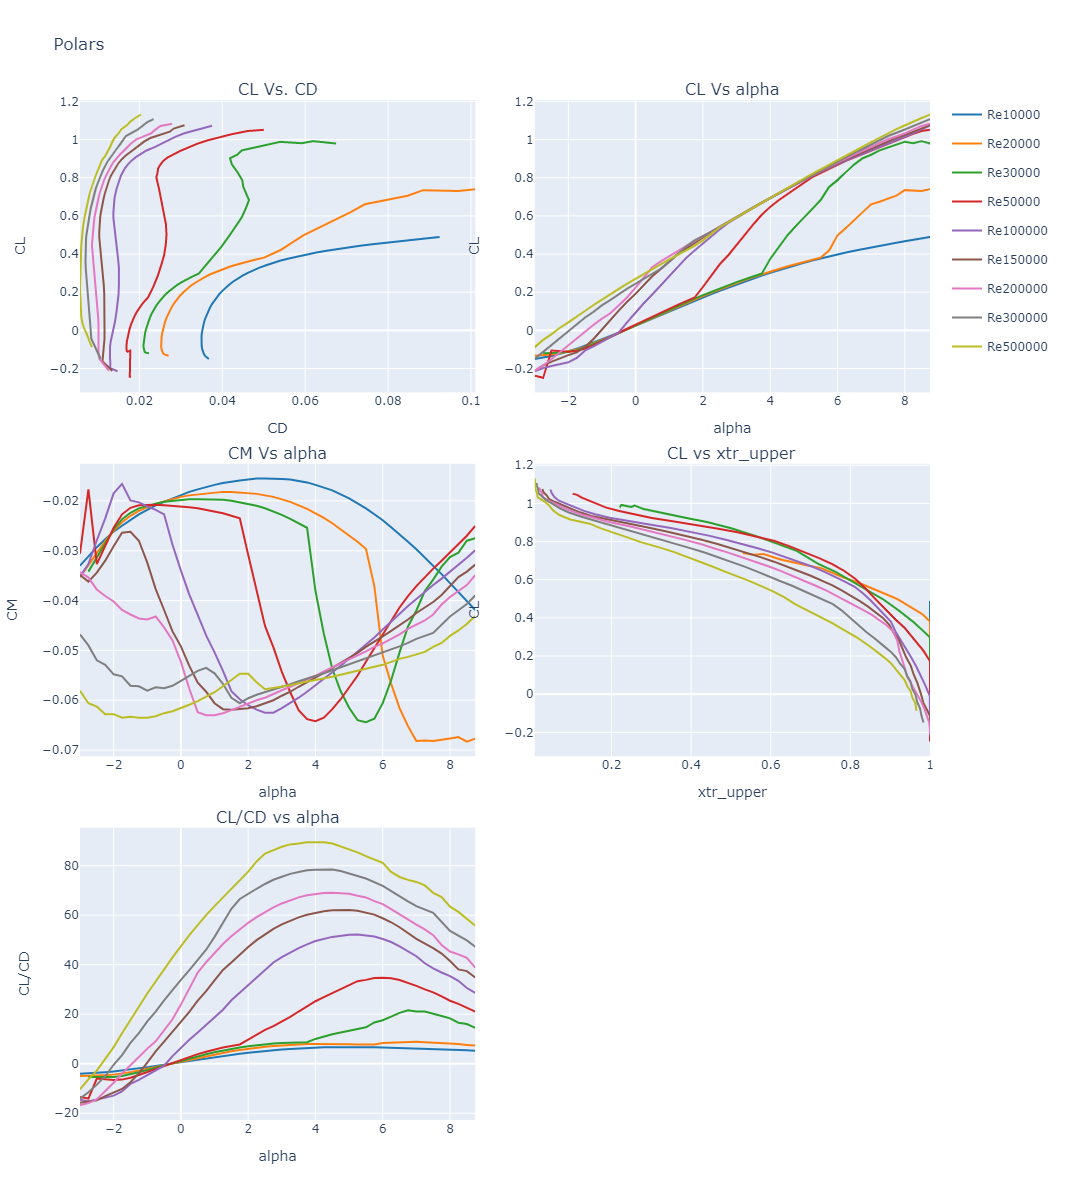

In [143]:
graphPolars(polars)

OpenVSP
=======

Convert an OpenVSP file to stl and display it in 3D

In [1]:
import openvsp as vsp
from enum import Enum
from functools import partial
Enum0 = partial(Enum, start=0)
ExportCode = Enum0('ExportCode', 'EXPORT_FELISA EXPORT_XSEC EXPORT_STL EXPORT_AWAVE EXPORT_NASCART EXPORT_POVRAY ' +
                   'EXPORT_CART3D EXPORT_VORXSEC EXPORT_XSECGEOM EXPORT_GMSH EXPORT_X3D')
file_format = ExportCode.EXPORT_STL
file_format = file_format.value
filename = '/sample/openvsp/Airbus_Beluga.vsp.vsp3'
filenamestl = './sample/openvsp/Airbus_Beluga.stl'
vsp.ClearVSPModel()
vsp.ReadVSPFile(filename)
vsp_set=0
vsp.ExportFile(filenamestl, vsp_set, file_format)

'AULNRSFHCL'

In [16]:
from stl import mesh
from pythreejs import *
from ipywidgets import HTML, Text, Output, VBox
import math

# find the max dimensions, so we can know the bounding box, getting the height,
# width, length (because these are the step size)...
def find_mins_maxs(obj):
    minx = obj.x.min()
    maxx = obj.x.max()
    miny = obj.y.min()
    maxy = obj.y.max()
    minz = obj.z.min()
    maxz = obj.z.max()
    return minx, maxx, miny, maxy, minz, maxz

# Generate surface data:
view_width = 800
view_height = 600

stlmesh = mesh.Mesh.from_file('/sample/openvsp/Airbus_Beluga.stl')
minx, maxx, miny, maxy, minz, maxz = find_mins_maxs(stlmesh)
vertices = BufferAttribute(array=stlmesh.vectors, normalized=False)
geometry = BufferGeometry( attributes={'position': vertices}, )

material = MeshLambertMaterial(color='lightsteelblue', wireframe=True,transparent=True, opacity=0.5)
surf = Mesh(geometry=geometry,
           material=material,
           position=[-40, 0, 0])

# Set up picking bojects:
hover_point = Mesh(geometry=SphereGeometry(radius=0.05),
                   material=MeshLambertMaterial(color='hotpink'))

click_picker = Picker(controlling=surf, event='dblclick')
hover_picker = Picker(controlling=surf, event='mousemove')

# Set up scene:
key_light = DirectionalLight(color='white', position=[3, 5, 1], intensity=0.4)
c = PerspectiveCamera(position=[0, 55, 55], up=[0, 0, 1], aspect=view_width / view_height,
                      children=[key_light])
scene = Scene(children=[surf, c, hover_point, AmbientLight(intensity=0.8)])
renderer = Renderer(camera=c, scene=scene,
                    width=view_width, height=view_height,
                    controls=[OrbitControls(controlling=c), click_picker, hover_picker])


# Set up picking responses:
# Add a new marker when double-clicking:
out = Output()
def f(change):
    value = change['new']
    with out:
        print('Clicked on %s' % (value,))
    point = Mesh(geometry=SphereGeometry(radius=0.05), 
                 material=MeshLambertMaterial(color='red'),
                 position=value)
    scene.add(point)

click_picker.observe(f, names=['point'])

# Have marker follow picker point:
link((hover_point, 'position'), (hover_picker, 'point'))

# Show picker point coordinates as a label:
h = HTML()
def g(change):
    h.value = 'Point at (%.3f, %.3f, %.3f)' % tuple(change['new'])
g({'new': hover_point.position})
hover_picker.observe(g, names=['point'])

display(VBox([h, renderer, out]))

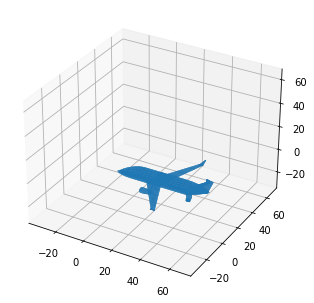

In [4]:
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot

# Create a new plot
figure = pyplot.figure()
axes = mplot3d.Axes3D(figure)

# Load the STL files and add the vectors to the plot
your_mesh = mesh.Mesh.from_file('/sample/openvsp/Airbus_Beluga.stl')
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(your_mesh.vectors))

# Auto scale to the mesh size
scale = your_mesh.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)

# Show the plot to the screen
pyplot.show()